# **A Web-based Tool for Automatic Discovery and Mapping of Global Vertical Land Motion (VLM) product**

By using this tool, you can search, download, and map **[Global Navigation Satellite System Imaging of Vertical Land Motion (VLM)](geodesy.unr.edu/vlm/VLM_Global_Imaged.txt)** from the Nevada Geodetic Laboratory at the University of Nevada Reno. This product is a static value VLM for each point. The interactive tool allows users to define their region of interest by drawing a polygon directly on the map.


**Reference**:
1. Hammond et al. (2021). GPS Imaging of Global Vertical Land Motion for Studies of Sea Level Rise. Journal of Geophysical Research: Solid Earth. https://doi.org/10.1029/2021JB022355 Date Accessed: 2025-09-18

---

Developed by **Dipen Saha**, and **Adnan Rajib**

[Hydrology and Hydroinformatics Innovation (H2I) Lab](https://www.adnanrajib.com), University of Texas at Arlington

# Install Pacakges

## User Guidelines

Purpose: Installs all required dependencies for your VLM workflow (geospatial processing, raster analysis, interactive mapping) inside Google Colab.


User Edits Needed: None, just run the cell once at the start of your Colab session.

Expected Output: Packages installed (some lines may show warnings or download logs, which you can ignore). After this, you can import everything without errors.

In [1]:
import sys
import os

# Add current directory to sys.path
sys.path.append(os.getcwd())

!{sys.executable} -m pip install leafmap

# Importing Packages

## User Guidelines

Loads all necessary libraries for VLM workflows (downloading, clipping, visualizing rasters, shapefiles, and interactive maps).

Install geopandas, rasterio, shapely, leafmap, ipyleaflet, localtileserver, ipywidgets, tqdm, matplotlib.

In [2]:
import os
import zipfile
import json
import requests
from tqdm.auto import tqdm
import gdown

# ---------- Data Handling ----------
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, mapping

# ---------- Raster Handling ----------
import rasterio
from rasterio.mask import mask
from rasterio.transform import from_bounds

# ---------- Visualization & Mapping ----------
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Leafmap (easy basemap & geospatial helpers)
import leafmap

# ipyleaflet core
from ipyleaflet import (
    Map, basemaps, DrawControl, LayersControl, Rectangle,
    CircleMarker, LayerGroup, GeoJSON, WidgetControl
)

# Local tile serving for raster layers
from localtileserver import TileClient, get_leaflet_tile_layer

# ---------- Jupyter/Colab Utilities ----------
import ipywidgets as widgets

import rioxarray as rxr
import base64
import matplotlib.pyplot as plt
from PIL import Image
import requests, folium, json, os, glob, matplotlib, gdown, gc, shutil, h5py, pyproj, textwrap, base64, warnings
from branca.element import Element

# Download the full global VLM file to local drive
## User Guidelines

Purpose: Download the UNR Global Vertical Land Motion (VLM) dataset (VLM_Global_Imaged.txt) directly into your local workspace.

Requirements: Requires requests and tqdm (already installed if you ran the earlier setup block).

User Edits Needed:

OUT_DIR → change if you want to store the file in a different folder .

Expected Output: Progress bar during download. 


The dataset will now be available locally for further processing.

In [3]:
URL = "https://geodesy.unr.edu/vlm/VLM_Global_Imaged.txt"  # UNR global VLM (mm/yr)
OUT_DIR = "Tools//data_VLM"
OUT_PATH = os.path.join(OUT_DIR, "VLM_Global_Imaged.txt")

os.makedirs(OUT_DIR, exist_ok=True)

def download_file(url, out_path):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        with open(out_path, "wb") as f, tqdm(
            total=total, unit="B", unit_scale=True, desc=os.path.basename(out_path)
        ) as p:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
                    p.update(len(chunk))

download_file(URL, OUT_PATH)
print("Saved:", OUT_PATH)

VLM_Global_Imaged.txt: 0.00B [00:00, ?B/s]

Saved: Tools//data_VLM/VLM_Global_Imaged.txt


# Draw your bounding box in the map

## User Guidelines

It automatically downloads the GeoTIFF file from Google Drive using its file ID, then displays it on a base map.

Make sure you have installed and enabled the required packages (rasterio, ipyleaflet, localtileserver, gdown, and the widget manager).

You can draw a red rectangle on the map to capture bounding box coordinates (printed below the map).

Edit center, map_zoom, or raster_cmap_name if you want a different location, zoom level, or color style.

The legend at the bottom right shows the VLM value range (mm/yr) based on the raster’s data.

In [4]:
# Map view
center = (28.6, -96.5)   # Texas coast
map_zoom = 6

# Display options
raster_cmap_name = "viridis"
raster_opacity   = 0.85
legend_title     = "Vertical Land Motion (mm/yr)"

file_id = "1ofDELiGuupym5_n8KLfPPG-n5kTnH3pw"
url = f"https://drive.google.com/uc?id={file_id}"
vlm_tif = os.path.join(OUT_DIR, "VLM_IDW_clipped.tif")
# ----------------------------------------------------

# ---------------- DOWNLOAD RASTER -------------------
print("Downloading VLM GeoTIFF from Google Drive...")
gdown.download(url, vlm_tif, quiet=False)

# ---------------- READ RASTER STATS -----------------
with rasterio.open(vlm_tif) as src:
    arr = src.read(1).astype(float)
    if src.nodata is not None:
        arr = np.where(arr == src.nodata, np.nan, arr)
    vmin = float(np.nanpercentile(arr, 2))
    vmax = float(np.nanpercentile(arr, 98))
    if not np.isfinite(vmin): vmin = float(np.nanmin(arr))
    if not np.isfinite(vmax): vmax = float(np.nanmax(arr))
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = 0.0, 1.0

# ---------------- BUILD THE MAP ---------------------
m = Map(center=center, zoom=map_zoom, basemap=basemaps.CartoDB.Positron)

# Serve the raster locally as tiles
client = TileClient(vlm_tif)
vlm_layer = get_leaflet_tile_layer(
    client,
    name="VLM (IDW)",
    opacity=raster_opacity,
    colormap=raster_cmap_name,
    vmin=vmin,
    vmax=vmax,
)
m.add_layer(vlm_layer)

# ---------------- DRAWING CONTROL (rectangles only) ---------------
dc = DrawControl(
    rectangle={"shapeOptions": {"color": "#FF3333", "fillOpacity": 0.0, "weight": 3}},
    polyline={}, polygon={}, circle={}, circlemarker={}, marker={}
)
bbox_coords = None  # (min_lon, min_lat, max_lon, max_lat)

def handle_draw(target, action, geo_json):
    global bbox_coords
    if action == "created" and geo_json.get("geometry", {}).get("type") == "Polygon":
        coords = geo_json["geometry"]["coordinates"][0]
        lons = [pt[0] for pt in coords]
        lats = [pt[1] for pt in coords]
        min_lon, max_lon = min(lons), max(lons)
        min_lat, max_lat = min(lats), max(lats)
        bbox_coords = (min_lon, min_lat, max_lon, max_lat)
        print(
            "Captured bbox:\n"
            f"  min_lon={min_lon:.6f}, min_lat={min_lat:.6f}, "
            f"max_lon={max_lon:.6f}, max_lat={max_lat:.6f}"
        )
        rect = Rectangle(bounds=((min_lat, min_lon), (max_lat, max_lon)),
                         color="#FF3333", fill=False, weight=3)
        m.add_layer(rect)

dc.on_draw(handle_draw)
m.add_control(dc)

# ---------------- LEGEND (matches raster stretch) ----------------
legend_html = f"""
<div style="
  background: white;
  padding: 10px 12px;
  border: 1px solid #ccc;
  border-radius: 6px;
  font-family: Arial, sans-serif;
  font-size: 12px;
  box-shadow: 0 1px 3px rgba(0,0,0,0.2);
  ">
  <div style="font-weight: 600; margin-bottom: 6px;">{legend_title}</div>
  <div style="
    height: 12px;
    width: 220px;
    background: linear-gradient(to right,
        rgba(68,1,84,1), rgba(59,82,139,1), rgba(33,144,141,1), rgba(94,201,98,1), rgba(253,231,37,1));
    margin: 6px 0 4px 0;
    border: 1px solid #999;
  "></div>
  <div style="display:flex; justify-content:space-between;">
    <span>{vmin:.2f}</span>
    <span>{vmax:.2f}</span>
  </div>
  <div style="margin-top:6px; color:#666;">Colormap: {raster_cmap_name}</div>
</div>
"""
legend_widget = widgets.HTML(value=legend_html)
legend_ctrl = WidgetControl(widget=legend_widget, position="bottomright")
m.add_control(legend_ctrl)

# Layers toggle
m.add_control(LayersControl(position="topright"))

m


Downloading...
From: https://drive.google.com/uc?id=1ofDELiGuupym5_n8KLfPPG-n5kTnH3pw
To: /scratch/11097/shihab_h2i_uta/tapis/3b0e8fce-bd0b-4c15-b3b8-e221f6610ee7-007/work/cookbooks/cookbook-h2iUTA-jupyter/Tools/Tools/data_VLM/VLM_IDW_clipped.tif
100%|██████████| 2.52M/2.52M [00:00<00:00, 10.8MB/s]


Map(center=[28.6, -96.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

# Clip Global VLM Data to Bounding Box

## User Guidelines

This code filters the global UNR VLM dataset to your drawn rectangle (bbox) and saves the subset to a text file.

Make sure you first draw a rectangle on the interactive map (previous cell) so that bbox_coords is not empty.

The code downloads and streams the large VLM dataset directly, only keeping rows that fall inside your bounding box.

After running, it prints how many rows were kept and saves them to VLM_bbox.txt for later use

In [5]:
# Make sure you’ve drawn the rectangle above first
if bbox_coords is None:
    raise SystemExit("No bbox yet. Go back to the map cell, draw a rectangle, then rerun this cell.")

(min_lon, min_lat, max_lon, max_lat) = bbox_coords
print("Using bbox:", bbox_coords)

URL = "https://geodesy.unr.edu/vlm/VLM_Global_Imaged.txt"

bbox_txt = os.path.join(OUT_DIR, "VLM_bbox.txt")

def stream_filter_bbox(url, out_path, bbox):
    (bx_min, by_min, bx_max, by_max) = bbox
    kept, total = 0, 0
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_path, "w") as f:
            for raw in r.iter_lines(decode_unicode=True):
                if raw is None:
                    continue
                line = raw.strip()
                if not line or line.startswith("#"):
                    continue
                total += 1
                parts = line.split()
                try:
                    lon, lat = float(parts[0]), float(parts[1])
                except Exception:
                    continue
                if (bx_min <= lon <= bx_max) and (by_min <= lat <= by_max):
                    f.write(line + "\n")
                    kept += 1
    return kept, total

kept, total = stream_filter_bbox(URL, bbox_txt, (min_lon, min_lat, max_lon, max_lat))
print(f"Kept {kept} of ~{total} rows into {bbox_txt}")


Using bbox: (-100.026567, 28.954471, -97.741835, 30.395769)
Kept 60 of ~274373 rows into Tools//data_VLM/VLM_bbox.txt


# Convert Filtered VLM Data to CSV

## User Guidelines

This code loads your clipped VLM text file (VLM_bbox.txt) into a DataFrame with clear column names.

The script automatically detects whether the file has 3, 4, or more columns and renames them sensibly (lon, lat, vlm_mm_per_yr, etc.).

It then saves the cleaned data to a CSV file (VLM_bbox.csv) inside your OUT_DIR.

Make sure you’ve run the previous bbox filtering step so that VLM_bbox.txt exists before running this.

The output shows the saved CSV path and how many rows were kept.

In [6]:
# Load text into DataFrame with sensible columns
df = pd.read_csv(bbox_txt, delim_whitespace=True, header=None, comment="#", engine="python")
if df.shape[1] == 3:
    df.columns = ["lon", "lat", "vlm_mm_per_yr"]
elif df.shape[1] == 4:
    df.columns = ["lon", "lat", "vlm_mm_per_yr", "sigma_mm_per_yr"]
elif df.shape[1] >= 5:
    base = ["lon", "lat", "vlm_mm_per_yr", "sigma_mm_per_yr"]
    base += [f"extra{i}" for i in range(1, df.shape[1] - 4 + 1)]
    df.columns = base[:df.shape[1]]
else:
    df.columns = [f"col{i}" for i in range(df.shape[1])]

# Save only CSV
csv_out = os.path.join(OUT_DIR, "VLM_bbox.csv")
df.to_csv(csv_out, index=False)

print("Saved CSV:", csv_out, "| rows:", len(df))

Saved CSV: Tools//data_VLM/VLM_bbox.csv | rows: 60


# Interpolate VLM Points with IDW and Export GeoTIFF

## User Guidelines (plain language)

This code takes your clipped VLM points, does an IDW interpolation, and saves a GeoTIFF you can put on the map.

Make sure VLM_bbox.csv exists (from earlier steps) or that gdf is already in memory.

If the map bbox isn’t in memory, the code auto-builds one from your points (with a small padding).

You can change grid size nx, ny for quality vs speed; larger = smoother but heavier.

IDW strength is set by power=2.0; increase it to make the surface follow nearby points more.


In [7]:
# ---------- Inputs ----------
csv_path = os.path.join(OUT_DIR, "VLM_bbox.csv")   # fallback if gdf not in memory
tif_path = os.path.join(OUT_DIR, "VLM_IDW.tif")

# Try to use in-memory data; else load CSV
try:
    _ = gdf  # if defined earlier
except NameError:
    df = pd.read_csv(csv_path)
    gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df["lon"], df["lat"])], crs="EPSG:4326")

try:
    (min_lon, min_lat, max_lon, max_lat) = bbox_coords
except NameError:
    pad = 0.05
    min_lon, min_lat = float(gdf["lon"].min()) - pad, float(gdf["lat"].min()) - pad
    max_lon, max_lat = float(gdf["lon"].max()) + pad, float(gdf["lat"].max()) + pad
bbox_coords = (min_lon, min_lat, max_lon, max_lat)

# ---------- Build grid ----------
nx, ny = 800, 800  # increase for smoother TIFF; reduce if memory is tight
xs = np.linspace(min_lon, max_lon, nx)
ys = np.linspace(min_lat, max_lat, ny)
XX, YY = np.meshgrid(xs, ys)

# ---------- IDW interpolation ----------
xp = gdf["lon"].to_numpy()
yp = gdf["lat"].to_numpy()
zp = gdf["vlm_mm_per_yr"].to_numpy().astype("float64")

eps = 1e-12
power = 2.0

Xflat = XX.ravel()[:, None]
Yflat = YY.ravel()[:, None]
dx = Xflat - xp[None, :]
dy = Yflat - yp[None, :]
dist2 = dx*dx + dy*dy + eps
weights = 1.0 / (dist2 ** (power/2))

num = (weights * zp[None, :]).sum(axis=1)
den = weights.sum(axis=1)
Z = (num / den).reshape(ny, nx).astype("float32")

# Optional: clip outliers for nicer display range
vmin, vmax = float(np.nanpercentile(Z, 2)), float(np.nanpercentile(Z, 98))

# ---------- Save GeoTIFF ----------
# IMPORTANT: rasters are written top->bottom (north->south). Our grid Y runs south->north,
# so we flip vertically to match the GeoTIFF's row order.
transform = from_bounds(min_lon, min_lat, max_lon, max_lat, nx, ny)
with rasterio.open(
    tif_path,
    "w",
    driver="GTiff",
    height=ny,
    width=nx,
    count=1,
    dtype="float32",
    crs="EPSG:4326",
    transform=transform,
    nodata=np.nan,
    compress="lzw",
) as dst:
    dst.write(Z[::-1, :], 1)

print("GeoTIFF saved:", tif_path)
print("Suggested display stretch (mm/yr):", f"{vmin:.2f} to {vmax:.2f}")


GeoTIFF saved: Tools//data_VLM/VLM_IDW.tif
Suggested display stretch (mm/yr): -1.22 to -0.39


# Visualize VLM GeoTIFF on Interactive Map

## User Guidelines

This code opens a new interactive map (leafmap) centered on your bbox and shows the interpolated VLM GeoTIFF.

It uses the viridis colormap with 85% opacity; you can change to another palette if you prefer.

The raster values are stretched between vmin and vmax (from earlier step).

A colorbar legend is added at the bottom with min/max values rounded to 1 decimal.

Run this after you’ve created the VLM_IDW.tif GeoTIFF — you should see your raster overlaid on the basemap.


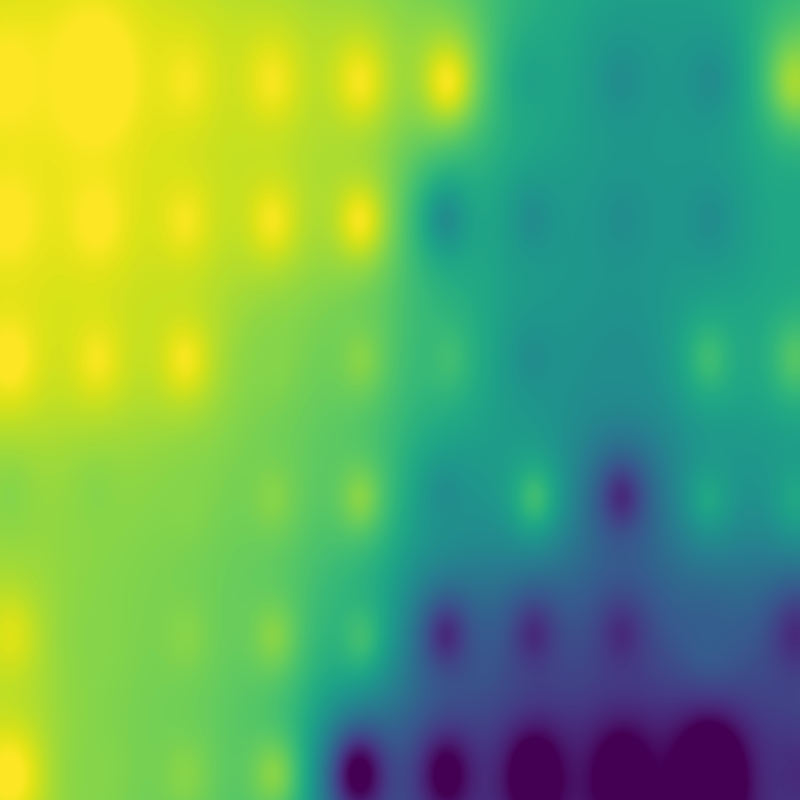

In [9]:
bounds = [[min_lat, min_lon], [max_lat, max_lon]]

lat = 0.5*(min_lat + max_lat) 
lon = 0.5*(min_lon + max_lon) 
center_lat = 0.5*(min_lat + max_lat) 
center_lon = 0.5*(min_lon + max_lon)



disp = rxr.open_rasterio(tif_path).squeeze()  # remove any extra band or time dims

disp_values = disp.values.copy()
disp_values = np.nan_to_num(disp_values, nan=np.nan)
vmin, vmax = np.nanpercentile(disp_values, [2, 98])
disp_clipped = np.clip(disp_values, vmin, vmax)
disp_norm = (disp_clipped - vmin) / (vmax - vmin)
cmap = plt.get_cmap('viridis')
disp_rgba = cmap(disp_norm)

# Handle NaNs in transparency
disp_rgba[..., 3] = np.where(np.isnan(disp_values), 0, 1)

# --- 🔧 Fix: remove extra dimensions
disp_rgba_img = (disp_rgba * 255).astype(np.uint8)
disp_rgba_img = np.squeeze(disp_rgba_img)  # remove dimensions of size 1

# Ensure shape is (H, W, 4)
if disp_rgba_img.shape[0] == 4 and disp_rgba_img.ndim == 3:
    disp_rgba_img = np.transpose(disp_rgba_img, (1, 2, 0))

img = Image.fromarray(disp_rgba_img, mode="RGBA")
img.save(OUT_DIR + "/disp_overlay.png")


m = folium.Map([lat, lon],zoom_start=10,tiles="cartodb positron")
m.add_child(folium.raster_layers.ImageOverlay(image=OUT_DIR+"/disp_overlay.png",bounds=bounds,colormap='viridis',
                                              opacity=1,interactive=True,overlay=True,name='VLM (mm/yr)'))
vmin, vmax = np.nanpercentile(disp_values, [2, 98])
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(0.6,3),dpi=200)
fig.subplots_adjust(right=0.5)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax)
cbar.set_label("Displacement (m)", fontsize=9)

# buf_leg = io.BytesIO()
# fig.savefig(buf_leg, format="png", bbox_inches="tight")
# plt.close(fig)
# url = "data:image/png;base64," + base64.b64encode(buf_leg.getvalue()).decode("utf-8")

legend_html = f"""
<div style="
  position: fixed; bottom: 10px; left: 10px; z-index: 9999;
  background: #fff; border: 1px solid #999; border-radius: 6px;
  padding: 10px 12px; box-shadow: 0 1px 4px rgba(0,0,0,0.3);
  font-size: 12px; line-height: 1.2; pointer-events: none;">

  <!-- centered title -->
  <div style="width:100%; text-align:center; font-weight:700;">VLM </div>
  <div style="width:100%; text-align:center; margin-bottom:6px;">Displacement (mm/yr)</div>

  <!-- colorbar row -->
  <div style="display:flex; align-items:center; gap:8px; justify-content:center;">
    <span style="min-width:42px; text-align:right;">{vmin:.2f}</span>
    <div style="
      height:14px; width:240px; border:1px solid #999; border-radius:3px;
      background: linear-gradient(to right,#440154,#482878,#3e4989,#31688e,#26828e,#1f9e89,#35b779,#6ece58,#b5de2b,#fde725);">
    </div>
    <span style="min-width:42px; text-align:left;">{vmax:.2f}</span>
  </div>
</div>
"""

m.get_root().html.add_child(Element(legend_html))

folium.LayerControl(collapsed=False).add_to(m)
display(m)